# Agent Framework

**Agent Framework** is a minimalistic Python framework designed to explore and understand the core abstractions behind modern agent-based AI systems. It simplifies the process of building conversational agents with capabilities for state management, tool integration, and conditional logic flow. Inspired by concepts from established frameworks like LangChain and LangGraph, this project aims to demystify the fundamental components of agent-based architectures. This notebook provides a comprehensive overview, detailed usage examples, and explanations of these concepts.

## Overview of the Framework's Components in this Notebook

### Tracer Components
Tracer components (e.g., `CallbackHandler`, `TraceLog`) monitor and log the execution process, allowing you to see how data flows and where actions begin and end.

### Runnable Components
These classes (e.g., `Runnable`, `RunnableLambda`, `RunnableParallel`) define how discrete chunks of logic are executed, chained, or branched. Each `Runnable` can be invoked and can inform callback handlers of its start and end.

### Utility Functions and Tool Definitions
Functions like `extract_json`, `append_to_state`, and `set_state_value` perform auxiliary tasks such as JSON handling and state manipulation, ensuring the core logic remains concise. Tool definitions encapsulate specialized functions like code execution or API calls that can be invoked by an AI agent.

### Tool (Runnable)
A `Tool` encapsulates a Python function in a runnable interface, complete with JSON schemas describing Tools can be called to perform specialized tasks (e.g., `check_weather`).
function arguments and return data.
### Node (Runnable)
A `Node` bundles an action (callable) with optional transitions. It can be chained or branched to form more complex logic steps within the system.

### Graph (Runnable)
A `Graph` holds `Nodes` and directed edges. It manages state and dictates the overall flow from one node to another, including handling conditional transitions.

### Chain-of-Thought Agent Example
This example demonstrates how the above components (e.g., `Graph`, `Nodes`, `Tools`) come together in an interactive conversational flow. It processes user input, decides when to invoke tools, and returns refined responses based on the conversation history.


## Imports

In [ ]:
!pip install google-generativeai pydantic tavily-python rich matplotlib typing-extensions

In [ ]:
from typing import Any, List, Optional, Dict, Tuple, Union, Callable
from abc import ABC, abstractmethod
from dotenv import load_dotenv, find_dotenv
from pydantic import ValidationError, BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import clear_output
from rich.markdown import Markdown, Panel
from rich.padding import Padding
from rich.style import Style
from rich.console import Console
import json
import inspect
import os
import requests
import subprocess
from matplotlib import pyplot as plt
import google.generativeai as genai

In [11]:
dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)

if "GEMINI_API_KEY" not in os.environ:
    os.environ["GEMINI_API_KEY"] = (
        "YOUR_GEMINI_API_KEY"  # from https://aistudio.google.com/apikey
    )
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = (
        "YOUR_TAVILY_API_KEY"  # from https://app.tavily.com/home
    )

## Tracer Components
Tracer components (CallbackHandler, TraceLog, etc.) monitor and log the execution process, allowing you to see how data flows and where actions begin and end.

In [12]:
class CallbackHandler(ABC):
    """Base class for handling callbacks during runnable execution."""

    @abstractmethod
    def on_invoke_start(
        self, runnable_name: str, input_data: Any, **kwargs: Any
    ) -> None:
        """Called when a runnable starts execution."""
        pass

    @abstractmethod
    def on_invoke_end(
        self, runnable_name: str, output_data: Any, **kwargs: Any
    ) -> None:
        """Called when a runnable completes execution."""
        pass


class TraceLog:
    """Maintains a list of trace messages for logging purposes."""

    def __init__(self):
        self.logs = []

    def add_log(self, message: str):
        """Adds a new message to the trace log."""
        self.logs.append(message)

    def get_logs(self) -> List[str]:
        """Returns all stored log messages."""
        return self.logs

    def clear_logs(self):
        """Clears all stored log messages."""
        self.logs = []


class TraceCallbackHandler(CallbackHandler):
    """Handles callbacks by storing them in a TraceLog with proper indentation."""

    def __init__(
        self, trace_log: TraceLog, indent_level: int = 0, indent_step: int = 2
    ):
        self.trace_log = trace_log
        self.indent_level = indent_level
        self.indent_step = indent_step

    def on_invoke_start(
        self, runnable_name: str, input_data: Any, **kwargs: Any
    ) -> None:
        """Records the start of a runnable execution in the trace log."""
        message = f"{' ' * self.indent_level}Starting: {runnable_name} with input: {input_data}"
        self.trace_log.add_log(message)
        self.indent_level += self.indent_step

    def on_invoke_end(
        self, runnable_name: str, output_data: Any, **kwargs: Any
    ) -> None:
        """Records the completion of a runnable execution in the trace log."""
        self.indent_level -= self.indent_step
        message = f"{' ' * self.indent_level}Finished: {runnable_name} with output: {output_data}"
        self.trace_log.add_log(message)


class ConsoleCallbackHandler(CallbackHandler):
    """Handles callbacks by printing them to the console."""

    def on_invoke_start(
        self, runnable_name: str, input_data: Any, **kwargs: Any
    ) -> None:
        """Prints the start of a runnable execution to the console."""
        print(f"Starting: {runnable_name} with input: {input_data}")

    def on_invoke_end(
        self, runnable_name: str, output_data: Any, **kwargs: Any
    ) -> None:
        """Prints the completion of a runnable execution to the console."""
        print(f"Finished: {runnable_name} with output: {output_data}")


class CallbackManager:
    """Manages multiple callback handlers and distributes callbacks to them."""

    def __init__(self, handlers: Optional[List[CallbackHandler]] = None) -> None:
        self.handlers = handlers or []

    def on_invoke_start(
        self, runnable_name: str, input_data: Any, **kwargs: Any
    ) -> None:
        """Notifies all handlers about the start of a runnable execution."""
        for handler in self.handlers:
            handler.on_invoke_start(runnable_name, input_data, **kwargs)

    def on_invoke_end(
        self, runnable_name: str, output_data: Any, **kwargs: Any
    ) -> None:
        """Notifies all handlers about the completion of a runnable execution."""
        for handler in self.handlers:
            handler.on_invoke_end(runnable_name, output_data, **kwargs)

## Runnable Components
These classes (Runnable, RunnableLambda, RunnableParallel, etc.) define how discrete chunks of logic are run, chained, or branched. Each Runnable can be invoked and can inform callback handlers of its start and end.

In [56]:
class Runnable(ABC):
    """Base class for all runnable components that can be chained together."""

    def __init__(self, name: Optional[str] = None):
        self.name = name or self.__class__.__name__

    def __or__(self, other: "Runnable") -> "Chain":
        return Chain(self, other)

    @abstractmethod
    def invoke(
        self, input_data: Any, callbacks: Optional[CallbackManager] = None, **kwargs
    ) -> Any:
        """Execute the runnable component with the given input."""
        pass


class RunnableLambda(Runnable):
    """Wraps a function to make it a runnable component."""

    def __init__(self, func: Callable, name: Optional[str] = None):
        super().__init__(name=name or func.__name__)
        self.func = func

    def invoke(
        self,
        input_data: Any,
        callbacks: Optional[CallbackManager] = None,
        **kwargs: Any,
    ) -> Any:
        """Execute the wrapped function with the given input."""
        if callbacks:
            callbacks.on_invoke_start(self.name, input_data, **kwargs)

        output = self.func(input_data)

        if callbacks:
            callbacks.on_invoke_end(self.name, output, **kwargs)
        return output


class RunnableParallel(Runnable):
    """Executes multiple runnables in parallel with the same input."""

    def __init__(self, runnables: Dict[str, Runnable], name: Optional[str] = None):
        super().__init__(name=name or "Parallel")
        self.runnables = runnables

    def invoke(
        self,
        input_data: Any,
        callbacks: Optional[CallbackManager] = None,
        **kwargs: Any,
    ) -> Dict[str, Any]:
        """Execute all runnables in parallel and return their outputs as a dictionary."""
        if callbacks:
            callbacks.on_invoke_start(self.name, input_data, **kwargs)

        output = {
            key: runnable.invoke(input_data, callbacks, **kwargs)
            for key, runnable in self.runnables.items()
        }

        if callbacks:
            callbacks.on_invoke_end(self.name, output, **kwargs)
        return output


class RunnablePassthrough(Runnable):
    """Passes through input data either completely or partially based on specified keys."""

    def __init__(
        self, passthrough_keys: Optional[List[str]] = None, name: Optional[str] = None
    ):
        super().__init__(name=name or "Passthrough")
        self.passthrough_keys = passthrough_keys

    def invoke(
        self,
        input_data: Any,
        callbacks: Optional[CallbackManager] = None,
        **kwargs: Any,
    ) -> Any:
        """Pass through the input data based on the configured passthrough keys."""
        if callbacks:
            callbacks.on_invoke_start(self.name, input_data, **kwargs)

        if self.passthrough_keys is None:
            output = input_data
        else:
            if len(self.passthrough_keys) == 1:
                key = self.passthrough_keys[0]
                output = input_data.get(key)
            else:
                output = {
                    key: input_data[key]
                    for key in self.passthrough_keys
                    if key in input_data
                }

        if callbacks:
            callbacks.on_invoke_end(self.name, output, **kwargs)
        return output


class RunnableBranch(Runnable):
    """Executes different runnables based on conditional logic."""

    def __init__(
        self, *branches: Tuple[Callable, Callable], name: Optional[str] = None
    ):
        super().__init__(name=name or "Branch")
        self.branches = branches

    def invoke(
        self,
        input_data: Any,
        callbacks: Optional[CallbackManager] = None,
        **kwargs: Any,
    ) -> Any:
        """Execute the first runnable whose condition evaluates to True."""
        if callbacks:
            callbacks.on_invoke_start(self.name, input_data, **kwargs)

        for condition, func in self.branches:
            if condition(input_data):
                output = func(input_data)
                if callbacks:
                    callbacks.on_invoke_end(self.name, output, **kwargs)
                return output
        return None


class LLM(Runnable):
    def __init__(self, model, generate_content_method, name="LLM"):
        self.name = name
        self.model = model
        self.generate_content_method = generate_content_method

    def invoke(
        self, query, callbacks: Optional[CallbackManager] = None, **kwargs: Any
    ) -> Dict:
        if callbacks:
            callbacks.on_invoke_start(self.name, query, **kwargs)
        result = self.generate_content_method(self.model, query)
        if callbacks:
            callbacks.on_invoke_end(self.name, result, **kwargs)
        return result


class Chain(Runnable):
    """Chains two runnables together, passing output of first as input to second."""

    def __init__(self, runnable1: Runnable, runnable2: Runnable):
        super().__init__(name=f"{runnable1.name} | {runnable2.name}")
        self.runnable1 = runnable1
        self.runnable2 = runnable2

    def invoke(
        self,
        input_data: Any,
        callbacks: Optional[CallbackManager] = None,
        **kwargs: Any,
    ) -> Any:
        """Execute both runnables in sequence."""
        if callbacks:
            callbacks.on_invoke_start(self.name, input_data, **kwargs)

        output1 = self.runnable1.invoke(input_data, callbacks=callbacks, **kwargs)
        output2 = self.runnable2.invoke(output1, callbacks=callbacks, **kwargs)

        if callbacks:
            callbacks.on_invoke_end(self.name, output2, **kwargs)
        return output2

## Utility Functions and Tool Definitions
Functions like extract_json, append_to_state, and set_state_value perform auxiliary tasks, such as JSON handling and state manipulation, ensuring the core logic remains concise. Tools encapsulate Python functions and their JSON schemas, allowing for easy integration into the system.

In [57]:
def is_valid_json(json_data, model_class):
    """Ensure that the JSON data is valid according to the specified Pydantic model."""
    try:
        _ = model_class.model_validate(json_data)
        return True, None
    except ValidationError as e:
        return False, e
    except Exception as e:
        return False, e


def extract_json(message):
    """Extract JSON data from a message."""
    try:
        if message.startswith("```json\n"):
            message = message[7:]
        elif message.startswith("```json"):
            message = message[6:]
        elif message.startswith("```"):
            message = message[3:]
        elif message.startswith("\n```json"):
            message = message[:-7]
        if message.endswith("```\n"):
            message = message[:-4]
        elif message.endswith("\n```"):
            message = message[:-4]
        elif message.endswith("```"):
            message = message[:-3]
        parsed_message = json.loads(message)
        return parsed_message
    except:
        print("extract_json: Error parsing JSON")
        return message


def append_to_state(state: Dict, key: Any, value: Any) -> Dict:
    """
    Append a value to a list in the state.
    """
    state[key].extend(value)
    return state


def set_state_value(state: Dict, key: Any, value: Any) -> Dict:
    """
    Set a value in the state.
    """
    state[key] = value
    return state


def speach_bubble(
    message,
    color="rgb(230,230,230)",
    bgcolor="rgb(30,30,30)",
    padding=(0, 0, 0, 25),
    use_panel=True,
    use_markdown=True,
):
    """Displays a formatted message in a speech bubble style using rich formatting."""
    console = Console()
    base_message = (
        message
        if not use_markdown
        else Markdown(message, style=Style(color=color, bgcolor=bgcolor))
    )
    base_message = (
        Panel(
            base_message,
            padding=(0, 1, 0, 1),
            border_style=Style(color=bgcolor),
            style=Style(color=color, bgcolor=bgcolor),
        )
        if use_panel
        else base_message
    )
    base_message = Padding(base_message, pad=padding, expand=True)
    console.print(base_message)


def add_numbers(a: int, b: int) -> int:
    """Adds two integer numbers together."""
    return a + b


def subtract_numbers(a: int, b: int) -> int:
    """Subtracts one integer number from another."""
    return a - b


def execute_python_code(python_code: str) -> str:
    """Executes Python code and returns the output."""
    try:
        result = subprocess.run(
            ["python3", "-c", python_code], capture_output=True, text=True, check=True
        )
        return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        return f"Error executing code: {e.stderr.strip()}"


def check_weather(city: str) -> str:
    """Gets the current weather for a specified city."""
    url = f"https://wttr.in/{city}?format=%C+%t"  # %C for weather condition, %t for temperature
    response = requests.get(url)

    if response.status_code == 200:
        return f"The current weather in {city} is: {response.text}"
    else:
        return f"Error fetching weather data for {city}. Please check the city name or try again later."


def plot_a_curve(x_values: list[float], y_values: list[float]) -> str:
    """Creates a simple line plot from x and y values."""
    plt.plot(x_values, y_values)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Curve Plot")
    plt.show()
    return "The Plot has been generated in the console."


def tavily_search(query: str, max_results: str = "5") -> str:
    """Performs a web search using Tavily API."""
    tavily_api_key = os.getenv("TAVILY_API_KEY")

    if not tavily_api_key:
        return "Error: Tavily API key not found. Please set the TAVILY_API_KEY environment variable."

    try:
        from tavily import TavilyClient

        tavily = TavilyClient(api_key=tavily_api_key)
        search_result = tavily.search(query=query, max_results=max_results)

        formatted_results = [
            f"Title: {result.get('title', 'No Title')}\nURL: {result.get('url', 'No URL')}\nContent: {result.get('content', 'No Content')}\n"
            for result in search_result.get("results", [])
        ]

        return (
            "\n\n".join(formatted_results) if formatted_results else "No results found."
        )

    except ImportError:
        return "Error: tavily-python package is not installed. Please install it using 'pip install tavily-python'."
    except Exception as e:
        return f"An error occurred during Tavily search: {str(e)}"

## Tool (Runnable)
A Tool encapsulates a Python function in a runnable interface, complete with JSON schemas describing function arguments and return data. Tools can be called to perform specialized tasks (e.g., check_weather).

In [58]:
class Tool(Runnable):
    """Converts Python functions into tool schemas that can be used by the framework."""

    def __init__(self, function):
        self.executable = function
        self.tool_json = self.create_tool(function)

    def create_tool(self, func):
        """Converts a Python function into a JSON schema describing its interface."""

        signature = inspect.signature(func)
        docstring = inspect.getdoc(func)

        schema = {
            "name": func.__name__,
            "description": docstring if docstring else "",
            "arguments": {"type": "object", "properties": {}, "required": []},
        }

        for param_name, param in signature.parameters.items():
            param_type = param.annotation

            if param_type is inspect.Parameter.empty:
                # Handle cases where the type hint is missing (default to "string")
                schema["arguments"]["properties"][param_name] = {
                    "description": param_name,
                    "type": "string",
                }
            elif isinstance(param_type, type):
                # Handle built-in types like int, str, list, dict
                schema["arguments"]["properties"][param_name] = {
                    "description": param_name,
                    "type": self.python_type_to_json_type(param_type),
                }
            elif getattr(param_type, "__origin__", None) is Union:
                # Handle Union types (represent as an "anyOf" array in JSON Schema)
                union_types = getattr(param_type, "__args__", [])
                schema["arguments"]["properties"][param_name] = {
                    "description": param_name,
                    "anyOf": [
                        {"type": self.python_type_to_json_type(t)}
                        for t in union_types
                        if t is not type(None)
                    ],
                }
                if type(None) in union_types:
                    schema["arguments"]["properties"][param_name]["nullable"] = True
            elif getattr(param_type, "__origin__", None) is list:
                # Handle List types (represent as an "array" in JSON Schema)
                item_type = getattr(param_type, "__args__", [inspect.Parameter.empty])[
                    0
                ]
                schema["arguments"]["properties"][param_name] = {
                    "description": param_name,
                    "type": "array",
                    "items": (
                        {"type": self.python_type_to_json_type(item_type)}
                        if item_type is not inspect.Parameter.empty
                        else {"type": "string"}
                    ),
                }

            elif getattr(param_type, "__origin__", None) is dict:
                # Handle Dict types (represent as an "object" in JSON Schema)
                schema["arguments"]["properties"][param_name] = {
                    "description": param_name,
                    "type": "object",
                    "additionalProperties": True,
                }
            else:
                # For more complex or custom types, default to "string"
                schema["arguments"]["properties"][param_name] = {
                    "description": param_name,
                    "type": "string",
                }

            if param.default is inspect.Parameter.empty:
                schema["arguments"]["required"].append(param_name)

        return schema

    def python_type_to_json_type(self, python_type):
        """Maps Python types to their corresponding JSON Schema type names."""
        if python_type == int:
            return "integer"
        elif python_type == float:
            return "number"
        elif python_type == str:
            return "string"
        elif python_type == bool:
            return "boolean"
        elif python_type == list:
            return "array"
        elif python_type == dict:
            return "object"
        elif python_type == type(None):
            return "null"
        else:
            return "string"  # Default to string for unknown types

    def invoke(
        self, arguments, callbacks: Optional[CallbackManager] = None, **kwargs: Any
    ):
        """Executes the wrapped function with the given arguments and manages callbacks."""
        if callbacks:
            callbacks.on_invoke_start(self.tool_json["name"], arguments, **kwargs)
        result = self.executable(**arguments)
        if callbacks:
            callbacks.on_invoke_end(self.tool_json["name"], result, **kwargs)
        return result


def tool(func):
    """Decorator that wraps a Python function into a Tool instance."""
    return Tool(func)

## Node (Runnable)
A Node bundles an action (callable) with optional transitions. It can be chained or branched to form more complex logic steps within the system.

In [59]:
class Node(Runnable):
    def __init__(self, name: str, action: Callable[[Dict], Dict]):
        """Initialize a Node with a name and an action."""
        self.name = name
        self.action = action
        self.next: Optional[Node] = None
        self.transitions: Dict[str, Node] = {}

    def __eq__(self, other: object) -> bool:
        """Compare two nodes for equality based on their names."""
        if isinstance(other, Node):
            return self.name == other.name
        return False

    def invoke(
        self, state: Dict, callbacks: Optional[CallbackManager] = None, **kwargs: Any
    ) -> Dict:
        """Execute the node's action and return the updated state."""
        if callbacks:
            callbacks.on_invoke_start(self.name, state, **kwargs)
        result = self.action(state)
        if callbacks:
            callbacks.on_invoke_end(self.name, result, **kwargs)
        return result

    def __repr__(self) -> str:
        """Return a string representation of the node."""
        return f"{self.name}"

## Graph (Runnable)
A Graph holds Nodes and directed edges. It manages state and dictates the overall flow from one node to another, including handling conditional transitions.

In [ ]:
class Graph(Runnable):
    def __init__(
        self,
        state_schema: Dict,
        update_mechanisms: Optional[Dict[str, Callable[[Dict, Any, Any], Dict]]] = None,
        name="Graph",
    ):
        """Initialize a new Graph with state schema and optional update mechanisms."""
        self.name = name
        self.nodes: List[Node] = []
        self.edges: List[tuple[str, str]] = []
        self.state: Dict = state_schema
        self.update_mechanisms: Dict[str, Callable[[Dict, Any, Any], Dict]] = (
            update_mechanisms or {}
        )
        self.start_node: Optional[Node] = None
        self.end_nodes: Optional[List[Node]] = None


    def add_node(self, node: Node) -> None:
        """Add a new node to the graph."""
        if node not in self.nodes:
            self.nodes.append(node)

    def add_edge(self, edge: tuple[Node, Node]) -> None:
        """Add a directed edge between two nodes in the graph."""
        if edge[0] not in self.nodes or edge[1] not in self.nodes:
            raise ValueError("Node not in graph." + edge[0].name + edge[1].name)
        if edge[0].next is None:
            edge[0].next = edge[1]

            # keep track of the edge in the edge list
            self.edges.append((edge[0].name, edge[1].name))
        else:
            raise ValueError("Node already has a next node.")

    def add_conditional_edges(
        self,
        source_node: Node,
        transition_resolver: Callable[[Dict], str],
        target_nodes: Dict[str, Node],
    ) -> None:
        """Add conditional edges from a source node to multiple target nodes."""
        if source_node not in self.nodes:
            raise ValueError("Source node not in graph." + source_node.name)

        conditional_node = Node(f"{source_node.name}_conditional", transition_resolver)
        self.add_node(conditional_node)
        self.add_edge((source_node, conditional_node))
        conditional_node.transitions = target_nodes

        # keep track of the new edges in the edge list
        self.edges.append((source_node.name, f"{source_node.name}_conditional"))
        for key, value in target_nodes.items():
            self.edges.append((f"{source_node.name}_conditional", value.name))

    def update_state(self, key: Any, value: Any) -> None:
        """Update the graph's state with a new key-value pair."""
        if key in self.update_mechanisms:
            self.update_mechanisms[key](self.state, key, value)
        else:
            self.state[key] = value

    def set_update_mechanism(
        self, key: Any, mechanism: Callable[[Dict, Any, Any], Dict]
    ) -> None:
        """Set a custom update mechanism for a specific state key."""
        self.update_mechanisms[key] = mechanism

    def set_start_node(self, node: Node) -> None:
        """Define the starting node of the graph."""
        if node not in self.nodes:
            raise ValueError("Node not in graph: " + node.name)
        self.start_node = node

    def set_end_nodes(self, nodes: Union[Node, List[Node]]) -> None:
        """Define the terminal nodes of the graph."""
        if isinstance(nodes, Node):
            nodes = [nodes]

        for node in nodes:
            if node not in self.nodes:
                raise ValueError("Node not in graph: " + node.name)
        self.end_nodes = nodes

    def invoke_next_node(
        self,
        current_node: Node,
        depth: int = 0,
        max_depth: Optional[int] = None,
        callbacks: Optional[CallbackManager] = None,
        **kwargs: Any,
    ) -> None:
        """Execute the next node in the graph's execution sequence."""
        if current_node in self.end_nodes or (
            max_depth is not None and depth >= max_depth
        ):
            return

        if current_node.name.endswith("_conditional"):
            next_node_name = current_node.invoke(
                self.state, callbacks=callbacks, **kwargs
            )
            if next_node_name in current_node.transitions:
                current_node = current_node.transitions[next_node_name]
            else:
                raise ValueError(f"Invalid transition: {next_node_name}")

        state_updates = current_node.invoke(
            state=self.state, callbacks=callbacks, **kwargs
        )

        if state_updates is not None:
            for key, value in state_updates.items():
                self.update_state(key, value)

        if current_node.next is not None:
            self.invoke_next_node(
                current_node.next,
                depth=depth + 1,
                max_depth=max_depth,
                callbacks=callbacks,
                **kwargs,
            )

    def invoke(
        self,
        state: Dict,
        max_depth: Optional[int] = None,
        callbacks: Optional[CallbackManager] = None,
        **kwargs: Any,
    ) -> None:
        """Execute the entire graph starting from the start node."""
        if callbacks:
            callbacks.on_invoke_start(self.name, state, **kwargs)
        self.state = state
        if self.start_node is None:
            raise ValueError("Start node not set.")
        if self.end_nodes is None:
            raise ValueError("End node not set.")

        self.invoke_next_node(
            self.start_node, depth=0, max_depth=max_depth, callbacks=callbacks, **kwargs
        )

        if callbacks:
            callbacks.on_invoke_end(self.name, self.state, **kwargs)

        return self.state

    def __repr__(self) -> str:
        """Return a string representation of the Graph."""
        return f"Graph(nodes={self.nodes}, edges={self.edges}, state={self.state})"

    def compile(self):
        """Return a compiled version of the Graph as a Runnable."""
        return self
    
    def plot(self) -> None:
        """Plot the graph using networkx with a spring layout."""
        try:
            import networkx as nx
        except ImportError:
            raise ImportError("Please install networkx to use this method.")

        G = nx.DiGraph()
        G.add_edges_from(self.edges)
        # pos = nx.spring_layout(G, k=0.5, iterations=100, scale=2)
        pos = nx.circular_layout(G)  # Use circular layout

        plt.figure(figsize=(12, 8))

        # Constants for rectangle size
        rect_width = 0.8
        rect_height = 0.2

        # Draw nodes with different colors and shapes
        for node, (x, y) in pos.items():
            color = "lightblue" if "_conditional" in node else "lightgreen"
            plt.gca().add_patch(
                plt.Rectangle(
                    (x - rect_width / 2, y - rect_height / 2),
                    rect_width,
                    rect_height,
                    facecolor=color,
                    edgecolor="black",
                    alpha=0.7,
                )
            )
            plt.text(x, y, node, fontsize=8, ha="center", va="center")

        # Draw edges with arrows
        for edge in G.edges():
            start_pos = pos[edge[0]]
            end_pos = pos[edge[1]]

            # Calculate direction vector
            dx = end_pos[0] - start_pos[0]
            dy = end_pos[1] - start_pos[1]
            length = (dx**2 + dy**2) ** 0.5

            # Normalize direction vector
            dx, dy = dx / length, dy / length

            # Adjust start and end points to rectangle borders
            start_x = start_pos[0] + dx * rect_width / 2
            start_y = start_pos[1] + dy * rect_height / 2
            end_x = end_pos[0] - dx * rect_width / 2
            end_y = end_pos[1] - dy * rect_height / 2

            if (edge[1], edge[0]) in G.edges():  # bidirectional edge
                plt.gca().annotate(
                    "",
                    xy=(end_x, end_y),
                    xytext=(start_x, start_y),
                    arrowprops=dict(
                        arrowstyle="->", connectionstyle="arc3,rad=0.2", color="gray"
                    ),
                )
            else:  # one-way edge
                plt.gca().annotate(
                    "",
                    xy=(end_x, end_y),
                    xytext=(start_x, start_y),
                    arrowprops=dict(
                        arrowstyle="->", connectionstyle="arc3,rad=0.1", color="gray"
                    ),
                )

        plt.margins(0.3)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

## Chain-of-Thought Agent Example
This demonstrates how the above pieces (Graph, Nodes, Tools, etc.) come together in an interactive conversational flow. It processes user input, decides when to invoke tools, and returns refined responses based on the conversation history.

In [64]:
# Define the system, i.e. the role of the AI
system = "You are a conversational assistant that shall reason and plan before giving an answer in a chain of thought. You have access to tools to help you. ALWAYS think step by step and explain your reasoning in a clear and understandable manner."

# Define the tools available to the AI
tools = json.dumps(tool(tavily_search).tool_json)
tools += "\nand\n"
tools += json.dumps(tool(execute_python_code).tool_json)
tools += "\nand\n"
tools += json.dumps(tool(check_weather).tool_json)
guidelines = """
**Tool Use Guidelines:**
- Use tools only when necessary
- MUST include clear user-facing summaries in "content" field explaining:
    - What tools you're using and why
    - Interpretation of tool outputs
    - Final conclusions/recommendations
- Execute tools sequentially in separate messages
- Follow exact argument types from schema:
    - Numbers as integers/floats (not strings)
    - Arrays with correct element types
    - Booleans as true/false
    - No expressions, only literal values
- Fix any type errors by adjusting arguments
"""
tool_usage = f"""
**You have access to the following tools:**
{tools}
{guidelines}
"""


# Define the output structure
class ToolCall(BaseModel):
    name: str = Field(..., description="The name of the tool.")
    arguments: Dict[str, str] = Field(
        {}, description="LITERAL_VALUE arguments for the tool."
    )


class Output(BaseModel):
    role: str = "AI"
    thought: str = Field(
        ...,
        description="The chain of thought that will be used to generate the response. In Markdown format",
    )
    content: str = Field(
        ...,
        description="Your answer, summarizing response or reasoning in Markdown format",
    )
    tool_calls: Optional[List[ToolCall]] = Field(
        None,
        description="The tool calls made by the conversational agent, can be null.",
    )


output_schema = Output.model_json_schema()
output_guidelines = f"""
Your responses MUST be written as a valid JSON object in the following structure:
{output_schema}
Violating these requirements will cause errors. Fix by adjusting the response format.
"""

try:
    genai.configure(api_key=os.environ["GEMINI_API_KEY"])
    model = genai.GenerativeModel(
        model_name="gemini-2.0-flash-exp",
    )
    llm = LLM(model, lambda model, query: model.generate_content(query).text)
except Exception as e:
    raise e


def create_ai_response(state: Dict) -> Dict:
    """Creates an AI response using the current conversation state."""
    prompt = f"""{system}\n{tool_usage}\n**Current Message History:**{state["messages"]}\n{output_guidelines}\nYou must ONLY provide the next message. Do NOT provide the output schema again."""
    llm_reply = llm.invoke(prompt)
    ai_message = extract_json(llm_reply)
    thought = ai_message["thought"]
    if state["show_cot"]:
        speach_bubble(
            f"Thought: {thought}",
            color="rgb(84,90,130)",
            use_panel=True,
            use_markdown=True,
        )
    return {"messages": [ai_message]}


def execute_tools(state: Dict) -> Dict:
    """Executes the tools requested by the AI assistant."""
    ai_message = state["messages"][-1]
    tool_calls = ai_message["tool_calls"]
    tool_responses = []
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        speach_bubble(
            f"Calling tool: {tool_name}",
            color="rgb(84,90,130)",
            use_panel=True,
            use_markdown=True,
        )
        arguments = tool_call["arguments"]
        if tool_name == "tavily_search":
            result = tavily_search(**arguments)
        elif tool_name == "execute_python_code":
            result = execute_python_code(**arguments)
        elif tool_name == "check_weather":
            result = check_weather(**arguments)
        else:
            raise ValueError(f"Tool {tool_name} not found.")
        tool_responses.append({"name": tool_name, "result": result})
    return {"messages": [{"role": "tools", "content": tool_responses}]}


def create_user_response(state: Dict) -> Dict:
    print()
    query = __builtins__.input()  # Call input from builtins module
    if query != "stop":
        clear_output(wait=True)
        speach_bubble(query, bgcolor="rgb(64,64,64)")
        print()
    return {"messages": [{"role": "user", "content": query}]}


def check_ai_output(state: Dict) -> str:
    """Validates AI output and determines the next action based on tool calls."""
    ai_message = state["messages"][-1]
    validated, error = is_valid_json(ai_message, Output)
    if not validated:
        state["messages"].append(
            {"role": "output_checker", "content": f"Error: {error}"}
        )
        return "ai_node"
    elif "tool_calls" in ai_message and ai_message["tool_calls"] is not None:
        return "tool_node"
    else:
        speach_bubble(ai_message["content"])
        return "user_node"


def determine_next_node(state: Dict) -> str:
    """Determines the next node based on special commands or continues normal flow."""
    if state["messages"][-1]["content"] == "show CoT":
        state["show_cot"] = True
        return "user_node"
    elif state["messages"][-1]["content"] == "hide CoT":
        state["show_cot"] = False
        return "user_node"
    elif state["messages"][-1]["content"] == "stop":
        return "END"
    elif state["messages"][-1]["content"] == "reset":
        state["messages"] = []
        return "user_node"
    return "ai_node"


def END_response(state: Dict):
    """Handles the end of conversation state."""
    return None


def define_CoT_graph():
    """Defines the conversation flow graph with all nodes and edges."""

    # Define the state schema
    class State(TypedDict):
        messages: List[Dict[str, str]]
        show_cot: bool = False

    state_graph = Graph(
        state_schema=State, update_mechanisms={"messages": append_to_state}
    )

    # Define the nodes
    ai_node = Node("ai_node", create_ai_response)
    tool_node = Node("tool_node", execute_tools)
    user_node = Node("user_node", create_user_response)
    end_node = Node("END", END_response)

    # Add the nodes to the graph
    state_graph.add_node(user_node)
    state_graph.add_node(ai_node)
    state_graph.add_node(tool_node)
    state_graph.add_node(end_node)
    state_graph.set_start_node(user_node)
    state_graph.set_end_nodes(end_node)

    # Add the edges to the graph
    state_graph.add_conditional_edges(
        user_node,
        determine_next_node,
        {"ai_node": ai_node, "END": end_node, "user_node": user_node},
    )
    state_graph.add_conditional_edges(
        ai_node,
        check_ai_output,
        {"ai_node": ai_node, "user_node": user_node, "tool_node": tool_node},
    )
    state_graph.add_edge((tool_node, ai_node))

    return state_graph

**Define the graph and plot its topology**

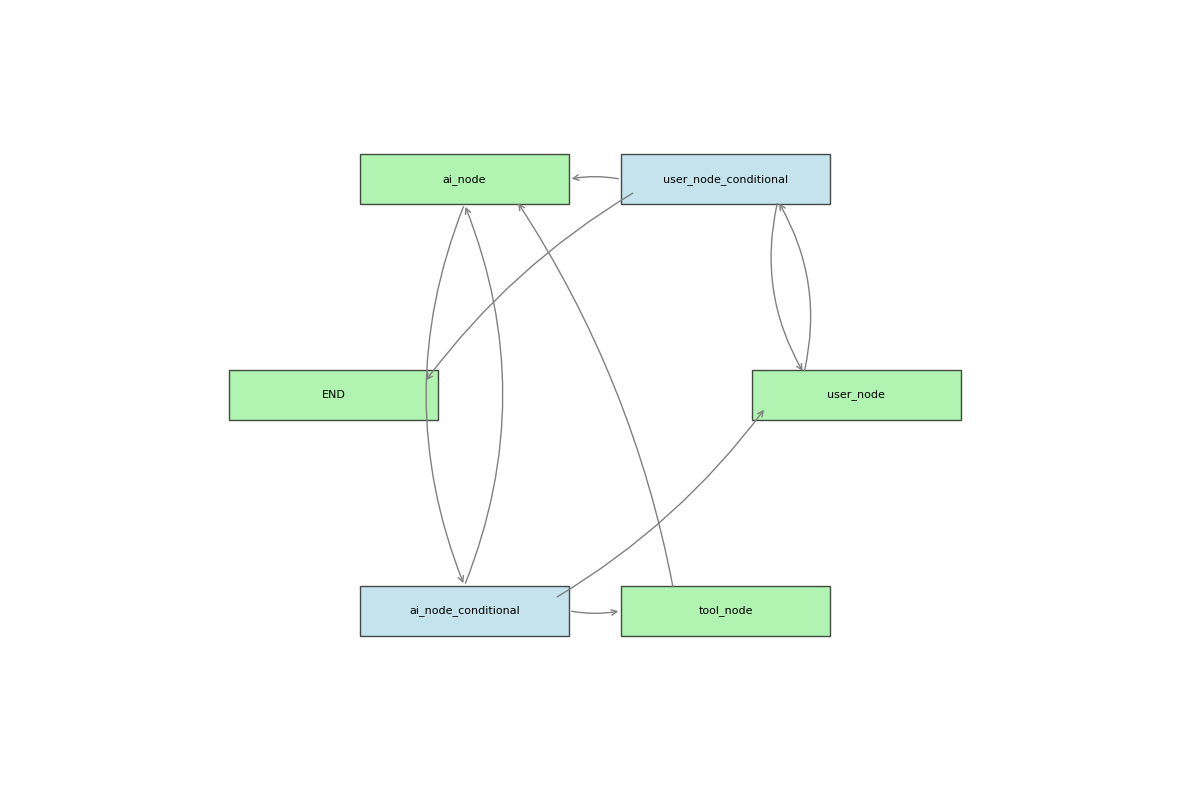

In [68]:
# Create a TraceLog instance
trace_log = TraceLog()
trace_callback_handler = TraceCallbackHandler(trace_log)
callback_manager = CallbackManager([trace_callback_handler])

# Define the chain with the graph
graph = define_CoT_graph().compile()
graph.plot()

**Initialize and run the Chain of Thought chat system and trace the execution.**

In [69]:
# Execute the workflow with an initial input
input = {"messages": [], "show_cot": True}
chain = graph | RunnableLambda(lambda x: x["messages"])
_ = chain.invoke(input, callbacks=callback_manager)

╭────────────────────────────────────────────────────────────────────────────────────────╮
                         │ what are agents?                                                                       │
                         ╰────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────────────────────────────────────────╮
                         │ Thought: The user is asking a general question about 'agents'. To provide a            │
                         │ comprehensive answer, I should use a search engine to gather information on this       │
                         │ topic. I will use the 'tavily_search' tool for this purpose.                           │
                         ╰────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────────────────────────────────────────╮
                         │ Calling tool: tavily_search                                                            │
                         ╰────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────────────────────────────────────────╮
                         │ Thought: I have gathered information about agents from the web search. Based on the    │
                         │ search results, agents in the context of computer science and AI are software programs │
                         │ or systems that interact with their environment, collect data, make decisions, and     │
                         │ take actions to achieve specific goals. They can learn about their environment and     │
                         │ perform self-determined actions. I will summarize these key aspects in my response.    │
                         ╰────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────────────────────────────────────────╮
                         │ In the context of computer science and artificial intelligence, an agent is a software │
                         │ program or system that is designed to perceive its environment, make decisions, and    │
                         │ take actions to achieve specific goals. These agents can learn from their interactions │
                         │ with the environment and perform self-determined actions. They are used in a wide      │
                         │ range of applications to solve various problems.                                       │
                         ╰────────────────────────────────────────────────────────────────────────────────────────╯

**Access the Agent's trace**

In [70]:
print("\n\nTrace Log:")
for log_entry in trace_log.get_logs():
    print()
    print(log_entry)



Trace Log:

Starting: Graph | <lambda> with input: {'messages': [], 'show_cot': True}

  Starting: Graph with input: {'messages': [], 'show_cot': True}

    Starting: user_node with input: {'messages': [], 'show_cot': True}

    Finished: user_node with output: {'messages': [{'role': 'user', 'content': 'what are agents?'}]}

    Starting: user_node_conditional with input: {'messages': [{'role': 'user', 'content': 'what are agents?'}], 'show_cot': True}

    Finished: user_node_conditional with output: ai_node

    Starting: ai_node with input: {'messages': [{'role': 'user', 'content': 'what are agents?'}], 'show_cot': True}

    Finished: ai_node with output: {'messages': [{'thought': "The user is asking a general question about 'agents'. To provide a comprehensive answer, I should use a search engine to gather information on this topic. I will use the 'tavily_search' tool for this purpose.", 'content': "I will now use a search engine to gather information about 'agents'.", 'tool_cal